Index(['height', 'outflow', 'pump1_rpm', 'pump1_power', 'pump4_rpm',
       'pump4_power'],
      dtype='object')


<bound method Figure.show of <Figure size 640x480 with 2 Axes>>

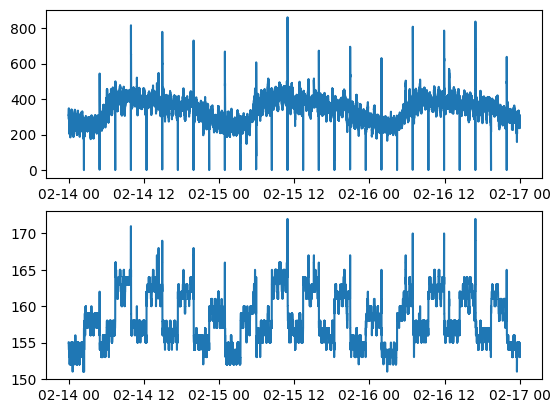

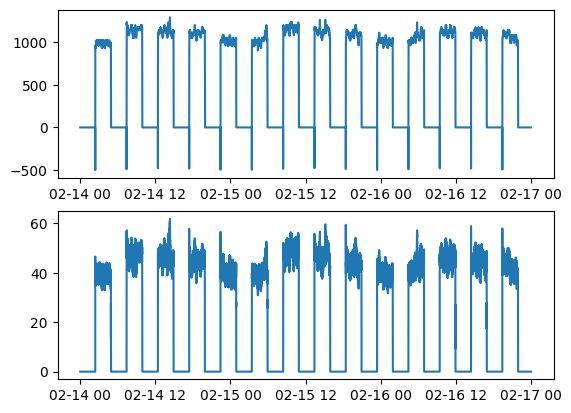

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_parquet('Data/pump_station_data.parquet')
data = data[:]["2023-02-14":"2023-02-16"]
print(data.columns)
fig, ax = plt.subplots(2)
ax[0].plot(data['outflow'])
ax[1].plot(data['height'])
fig.show
fig, ax = plt.subplots(2)
ax[0].plot(data['pump1_rpm'])
ax[1].plot(data['pump1_power'])
fig.show

# Building a static model of the 


In [2]:
import sklearn.model_selection as modsel

data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)


In [3]:
# Format the data so that it can be used to fit the ARX model
# The rpm values of both pumps are chosen as input values
x_train = data_train.drop(labels=['height','outflow', 'pump1_rpm', 'pump4_rpm'], axis=1)
x_train = x_train.to_numpy()
y_train = data_train['outflow'].values.reshape(-1,1)

x_test = data_test.drop(labels=['height','outflow', 'pump1_rpm', 'pump4_rpm'], axis=1)
x_test = x_test.to_numpy()
y_test = data_test['outflow'].values.reshape(-1,1)

In [4]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [5]:

# The model is fitted 
basis_function= Polynomial(degree=1)
rrse_low = 1
i_j_a_h_best = []
yhat_best = []
model = FROLS(
    order_selection=True,
    n_terms = 6,
    extended_least_squares=False,
    ylag=1,
    xlag=[[1, 17],[1,17]],
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
    )
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_test,y=y_test)
rrse = root_relative_squared_error(y_test, yhat)

                                
                                
                                   

    

/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6
  self.info_values = self.information_criterion(reg_matrix, y)


In [6]:
print(i_j_a_h_best)
print(rrse)

[]
0.48049884494233336


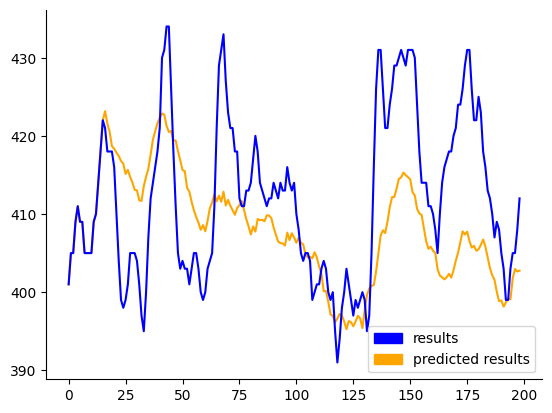

In [7]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat[1:200], color='orange')
ax.plot(y_test[1:200], color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()

In [8]:
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

  Regressors   Parameters             ERR
0     y(k-1)   9.8685E-01  9.99888384E-01
1          1  -4.2814E+00  7.03943391E-08
2    x2(k-1)   6.8818E-01  2.21073881E-08
3   x2(k-17)  -4.6099E-01  6.67136503E-06
4    x1(k-1)   5.4238E-01  3.21397794E-06
5   x1(k-17)  -3.4074E-01  2.47062974E-06


In [9]:
from sklearn.linear_model import BayesianRidge
from sysidentpy.general_estimators import NARX
from sysidentpy.basis_function._basis_function import Polynomial
basis_function= Polynomial(degree=1)
rrse_low = 1
i_j_a_best = []
yhat_best = []

BayesianRidge_narx = NARX(
base_estimator=BayesianRidge(),
xlag=[[1, 14],[1,14],[1,14]],
ylag=3,
basis_function=basis_function,
model_type="NARMAX",
)

BayesianRidge_narx.fit(X=x_train, y=y_train)
yhat = BayesianRidge_narx.predict(X=x_test,y=y_test)
rrse_narx= root_relative_squared_error(y_test, yhat)
print(rrse_narx)
                                

                




0.48300259410060137


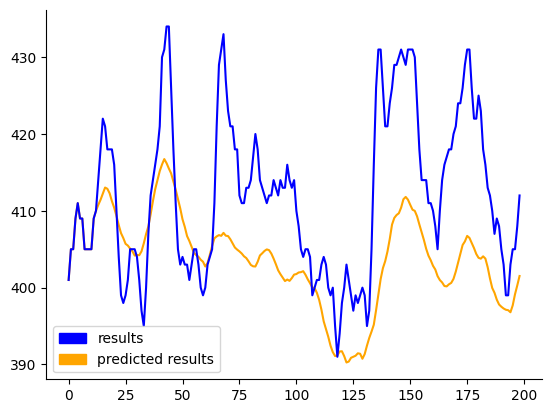

In [10]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat[1:200], color='orange')
ax.plot(y_test[1:200], color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()


In [11]:
print(i_j_a_best)
print(rrse_low)

[]
1


In [12]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

torch.manual_seed(0)

Using cuda device


In [13]:
# TODO: Do the training on a short period of time for each pump individually to get a got estimation

In [14]:
# basis_function = Polynomial(degree=1)
# rrse_low = 1
# yhat_best = []

# narx_net = NARXNN(
#         ylag=2,
#         xlag=[[5], [5]],
#         basis_function=basis_function,
#         model_type="NARMAX",
#         loss_func="mse_loss",
#         optimizer="Adam",
#         epochs=100,
#         learning_rate = 4e-3,
#         verbose=False,
#         device='cuda',
#         optim_params={
#             "betas": (0.9, 0.999),
#             "eps": 1e-05,
#         }, 
#     )
# class NARX(nn.Module):
#         def __init__(self):
#             super().__init__()
#             self.lin = nn.Linear(4, 30)
#             self.lin2 = nn.Linear(30, 30)
#             self.lin3 = nn.Linear(30, 1)
#             self.tanh = nn.Tanh()

#         def forward(self, xb):
#             z = self.lin(xb)
#             z = self.tanh(z)
#             z = self.lin2(z)
#             z = self.tanh(z)
#             z = self.lin3(z)
#             return z
# narx_net.net = NARX()
# if device == "cuda": 
#     narx_net.net.to(torch.device("cuda"))
# narx_net.fit(X=x_train, y=y_train,X_test=x_test, y_test=y_test)
# yhat_best = narx_net.predict(X=x_test, y=y_test)
# print("MSE: ", mean_squared_error(y_test, yhat))
# rrse = root_relative_squared_error(y_, yhat)
# print("RRSE: ",rrse)
    
   
                                


In [15]:
# print("MSE: ", mean_squared_error(y_test, yhat_best))
# rrse = root_relative_squared_error(y_test, yhat_best)
# print("RRSE: ",rrse)
    


In [16]:
""" 
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat_best, color='orange')
ax.plot(y_test, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()
 """

" \nimport matplotlib.patches as mpatches\nfig, ax = plt.subplots()\nax.plot(yhat_best, color='orange')\nax.plot(y_test, color='blue')\norange_patch = mpatches.Patch(color='orange', label='predicted results')\nblue_patch = mpatches.Patch(color='blue', label='results')\nax.legend(handles=[blue_patch,orange_patch])\n\nplt.show()\n "

In [17]:
import sklearn.model_selection as modsel

data_train, data_test = modsel.train_test_split(data['2023-02-14 12:27:00':'2023-02-14 13:50:00'], test_size=0.2, shuffle=False)



# Format the data so that it can be used to fit the ARX model
# The rpm values of both pumps are chosen as input values
x_train_1 = data_train.drop(labels=['height','outflow', 'pump1_power','pump4_power', 'pump4_rpm'], axis=1)
x_train_1 = x_train_1.values.reshape(-1,1)
y_train_1 = data_train['outflow'].values.reshape(-1,1)

x_test_1 = data_test.drop(labels=['height','outflow', 'pump1_power','pump4_power', 'pump4_rpm'], axis=1)
x_test_1 = x_test_1.values.reshape(-1,1)
y_test_1 = data_test['outflow'].values.reshape(-1,1)






In [18]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

Using cuda device


In [21]:
basis_function = Polynomial(degree=1)
eval_dict={}
rrse_low = 1
i_best = 0
yhat_best = []
for i in ["PReLU", 'ReLU', 'RReLU', 'SELU', 'CELU', 'GELU', 'Sigmoid', 'SiLU','Mish','Softplus']:
    narx_net = NARXNN(
            ylag=2,
            xlag= 3,
            basis_function=basis_function,
            model_type="NARMAX",
            loss_func="mse_loss",
            optimizer="Adam",
            epochs=5000,
            device='cuda',
            learning_rate = 4e-3,
            verbose=False,
            optim_params={
                "betas": (0.9, 0.999),
                "eps": 1e-05,
            }, 
        )
    class NARX(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.lin = nn.Linear(5, 30)
                    self.lin2 = nn.Linear(30, 64)
                    self.lin3 = nn.Linear(64, 64)
                    self.lin4 = nn.Linear(64, 30)               
                    self.lin5 = nn.Linear(30, 1)
                    self.tanh = eval("nn."+i+"()")
                    

                def forward(self, xb):
                    z = self.lin(xb)
                    z = self.tanh(z)
                    z = self.lin2(z)
                    z = self.tanh(z)
                    z = self.lin3(z)
                    z = self.tanh(z)
                    z = self.lin4(z)
                    z = self.tanh(z)
                    z = self.lin5(z)
                    z = self.tanh(z)
                    
                    return z
    narx_net.net = NARX()
    if device == "cuda": 
        narx_net.net.to(torch.device("cuda"))
    narx_net.fit(X=x_train_1, y=y_train_1,X_test=x_test_1, y_test=y_test_1)
    yhat = narx_net.predict(X=x_test_1, y=y_test_1)
    mse = mean_squared_error(y_test_1, yhat)
    print("MSE: ", mse)
    rrse = root_relative_squared_error(y_test_1, yhat)
    print("RRSE: ",rrse)   
    eval_dict.update({i:{"rrse":rrse,"mse":mse,'yhat':yhat}})
   

MSE:  1321.61329126608
RRSE:  2.3324504002496513
MSE:  162129.46138415247
RRSE:  25.83397222710325
MSE:  168.32363774239224
RRSE:  0.8324013436623003
MSE:  5628.868317223882
RRSE:  4.813608471475236
MSE:  nan
RRSE:  nan
MSE:  162129.46138415247
RRSE:  25.83397222710325
MSE:  161326.95386158474
RRSE:  25.76995648531666
MSE:  736.2770476645642
RRSE:  1.7409281572748772
MSE:  162129.46138415247
RRSE:  25.83397222710325
MSE:  717.8814222365347
RRSE:  1.7190423486182727


In [22]:

print(eval_dict["RReLU"])

{'rrse': 0.8324013436623003, 'mse': 168.32363774239224, 'yhat': array([[443.     ],
       [447.     ],
       [447.     ],
       [440.13782],
       [435.01804],
       [431.026  ],
       [428.32648],
       [425.14972],
       [423.204  ],
       [421.25876],
       [418.38818],
       [416.343  ],
       [413.96213],
       [412.76282],
       [412.05423],
       [410.8046 ],
       [410.1049 ],
       [409.6821 ],
       [409.80548],
       [409.11078],
       [409.13324],
       [408.88416],
       [408.93076],
       [408.62216],
       [408.758  ],
       [408.26065],
       [407.9037 ],
       [408.09146],
       [406.92944],
       [406.89026],
       [406.9243 ],
       [406.56314],
       [406.4984 ],
       [406.90472],
       [407.7347 ],
       [409.68365],
       [411.12808],
       [412.26257],
       [413.34354],
       [413.99307],
       [414.7651 ],
       [414.92157],
       [415.0329 ],
       [415.03772],
       [415.48764],
       [414.8281 ],
       [413.0693

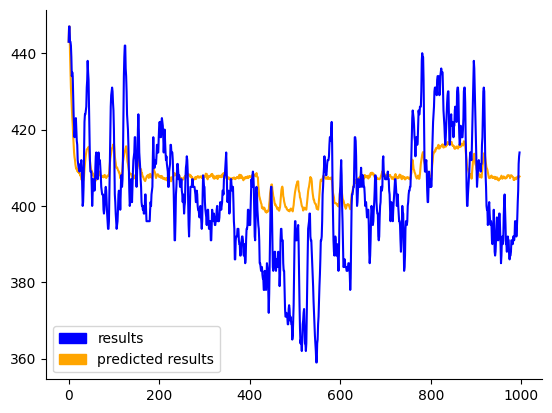

In [23]:

import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(eval_dict["RReLU"]['yhat'], color='orange')
ax.plot(y_test_1, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()